# Introduction

This code explores the BER vs SNR characteristics for 3 different channels 
- AWGN
- AWGN + Rayleigh
- AWGN + Rayleigh with Jakes correlation

### Defining Helper Functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import json
from statsmodels.tsa.ar_model import AutoReg
import numpy as npa
from sympy import Matrix
import json
import argparse
from math import log

In [152]:
def transmit_data(data, channel, snr_db):
    # Apply channel gain to the transmitted data.
    signal = channel * data
    # Calculate the signal power.
    signal_power = np.mean(np.abs(signal)**2)
    # Convert SNR from dB to linear scale and compute noise power.
    noise_power = signal_power / (10**(snr_db / 10))
    # Generate complex Gaussian noise.
    noise = np.sqrt(noise_power / 2) * (np.random.randn(len(data)) + 1j * np.random.randn(len(data)))
    # Add noise to the signal to create the received signal.
    return signal + noise

def transmit_data_awgn(data, snr_db):
    # Apply channel gain to the transmitted data.
    signal = data
    # Calculate the signal power.
    signal_power = np.mean(np.abs(signal)**2)
    # Convert SNR from dB to linear scale and compute noise power.
    noise_power = signal_power / (10**(snr_db / 10))
    # Generate complex Gaussian noise.
    noise = np.sqrt(noise_power / 2) * (np.random.randn(len(data)) + 1j * np.random.randn(len(data)))
    # Add noise to the signal to create the received signal.
    return signal + noise

def decoder_custom_jakes(received, channel):
    list1 = np.sign(np.real(received / channel))
    list2 = []
    for i in list1:
        if i == -1:
            list2.append(1)
        if i == 1:
            list2.append(0)
    return list2

def decoder_custom_awgn(received):
    list1 = np.sign(np.real(received))
    list2 = []
    for i in list1:
        if i == -1:
            list2.append(1)
        if i == 1:
            list2.append(0)
    return list2



def generate_random_symbols(n):
    # Generate n random bits as -1 or 1 using uniform sampling.
    return np.random.choice([-1, 1], size=n)

def generate_channels_for_doppler_frequencies(Fd, Fs, N):
    """
    Generate correlated Jakes channels for given Doppler frequencies using the Sum-of-Sinusoids (SoS) method.

    Args:
        Fd (float): Maximum Doppler frequency (Hz).
        Fs (float): Sampling frequency (Hz).
        N (int): Number of samples to generate.

    Returns:
        np.ndarray: Correlated Jakes random variables (complex values) for the generated channels.
    """
    def jakes_sos(P, K, Fs, Fd, N, typ):
        """
        Generate Jakes random variables using the Sum-of-Sinusoids (SoS) method.

        Args:
            P (int): Number of time points.
            K (int): Number of independent processes.
            Fs (float): Sampling frequency (Hz).
            Fd (float): Maximum Doppler frequency (Hz).
            N (int): Number of sinusoids used in the model.
            typ (str): Type of signal to generate ('comp' for complex, others for real).

        Returns:
            np.ndarray: Jakes random variables (complex values).
        """
        # Create a time vector for sampling points
        t = np.linspace(0, P / Fs, P)
        # Calculate angular Doppler frequency
        omega_d = 2 * np.pi * Fd
        # Initialize an array to store Jakes random variables
        jakes_rvs = np.zeros((K, P), dtype=complex)
        
        # Loop through independent processes
        for k in range(K):
            # Generate random angles for sinusoids
            alpha = np.random.uniform(0, 2 * np.pi, N)
            # Adjust angles based on the number of sinusoids
            alpha_m = np.array([((2 * np.pi * n) - np.pi + al) / (4 * N) for n, al in enumerate(alpha)])
            # Generate random phase offsets for cosine terms
            a_m = np.random.uniform(0, 2 * np.pi, N)
            # Generate random phase offsets for sine terms
            b_m = np.random.uniform(0, 2 * np.pi, N)
            # Compute cosine terms for the real part
            cosine_terms = np.cos((omega_d * t[:, None] * np.cos(alpha_m)) + a_m)
            # Sum the cosine contributions to form the real part
            real_part = np.sqrt(1 / N) * np.sum(cosine_terms, axis=1)

            # Check if generating complex signals
            if typ == 'comp':
                # Compute sine terms for the imaginary part
                sine_terms = np.sin((omega_d * t[:, None] * np.cos(alpha_m)) + b_m)
                # Sum the sine contributions to form the imaginary part
                imag_part = np.sqrt(1 / N) * np.sum(sine_terms, axis=1)
                # Combine real and imaginary parts
                jakes_rvs[k] = real_part + 1j * imag_part
            else:
                # Enforce complex format with zero imaginary part for real signals
                jakes_rvs[k] = real_part + 1j * 0

        # Return the generated Jakes random variables
        return jakes_rvs

    # Number of time points for the output
    P = N
    # Number of independent processes to simulate
    K = 1
    # Specify the type of random variables (complex)
    typ = 'comp'
    # Set the center frequency
    Fc = 1000000000
    # Generate Jakes random variables using the SoS method
    jakes_rvs = jakes_sos(P, K, Fs, Fd, 100, typ)
    correlated_jakes_rvs = jakes_rvs

    # Open a file to write the generated channels
    with open("channels.txt", "w") as fo:
        # Iterate through each sample
        for i in range(P):
            # Extract the i-th sample
            new_sample = correlated_jakes_rvs[:, i]
            # Serialize complex numbers as (real, imag) pairs
            new_sample_serialized = [(z.real, z.imag) for z in new_sample]
            # Write serialized sample to the file
            json.dump(new_sample_serialized, fo)
            # Add a newline after each serialized sample
            fo.write('\n')

    # Return the generated Jakes random variables
    return correlated_jakes_rvs

def estimate_channel(received, data):
    """
    Estimate the channel coefficient using least squares.

    Args:
        received (np.ndarray): Received signal.
        data (np.ndarray): Transmitted data.

    Returns:
        complex or float: Estimated channel coefficient, of the same length as X, so a packetwise(pointwise) estimation is performed
    """
    # Reshape the transmitted data for matrix operations.
    X = data.reshape(-1, 1)
    # Perform least squares estimation to solve for the channel.
    h = np.linalg.lstsq(X, received, rcond=None)[0][0]
    return h



### BER vs SNR for AWGN channel

In [181]:
def awgn_simulate(N, SNR):
    # Initialize variables for simulation.
    current_index = 0  # Track the current position in channel values.
    total_packets = 0  # Total number of transmitted data bits.
    wrong_packets = 0  # Count of incorrectly received data bits.
    
    while current_index < N:
        packet_message = np.random.randint(2, size = 1)
        current_index += 1
        packet_symbol = [-1 if j == 1 else 1 for j in packet_message]
        received_symbols = transmit_data_awgn(packet_symbol, SNR)
        recovered_message = decoder_custom_awgn(received_symbols)
        total_packets += 1
        if recovered_message != packet_message:
            wrong_packets += 1            
    if total_packets == 0:
        return None 
    else:
        return np.float16(wrong_packets / total_packets)       

In [196]:
# Define the range of SNR values to be simulated
snr_values = [-4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
N = 100000

# Initialize lists to store BER for the approaches
ber_awgn_list = []  # BER for the packetwise approach

# Simulation loop for each SNR value
# The simulation is peformed 3 times to ensure averaging and smoothness of the curve
for snr in snr_values:
    ber_sum_awgn = 0  # For packetwise approach
    for i in range(3):
        ber_awgn = awgn_simulate(N, snr)
        ber_sum_awgn += ber_awgn
    ber_awgn_list.append(ber_sum_awgn / 3)

### BER vs SNR for Rayleigh channel with AWGN

In [198]:
def rayleigh_simulate(N, SNR):
    wrong_packets = 0  # Count of incorrectly received data bits.
    channel_vals = (1 / np.sqrt(2)) * (np.random.randn(N) + 1j * np.random.randn(N)) 
    packet_message = np.random.randint(2, size = N)
    encoded_packet_symbols = [-1 if j == 1 else 1 for j in packet_message]
    received_symbols = transmit_data(encoded_packet_symbols, channel_vals, SNR)
    recovered_message = decoder_custom_jakes(received_symbols, channel_vals)
    for i in range(len(recovered_message)):
            if packet_message[i] != recovered_message[i]:
                wrong_packets += 1
    return np.float16(wrong_packets/N)
    #Return the BER            
    if total_packets == 0:
        return None  # Return None if no packets were transmitted.
    else:
        return np.float16(wrong_packets / total_packets)     

In [199]:
# Define the range of SNR values to be simulated
snr_values = [-4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
N = 100000

# Initialize lists to store BER for the approaches
ber_ray_list = []  # BER for the packetwise approach

# Simulation loop for each SNR value
# The simulation is peformed 3 times to ensure averaging and smoothness of the curve
for snr in snr_values:
    ber_sum_ray = 0  # For packetwise approach
    for i in range(3):
        ber_ray = rayleigh_simulate(N, snr)
        ber_sum_ray += ber_ray
    ber_ray_list.append(ber_sum_ray / 3)

### BER vs SNR for correlated Rayleigh channel (the channel is known)

In [201]:
def jakes_simulate(Fd, Fs, N, SNR):
    # Generate channels for the specified Doppler frequency and save to file.
    wrong_packets = 0
    generate_channels_for_doppler_frequencies(Fd, Fs, N)
    with open("channels.txt", "r") as f:
        channel_vals = [json.loads(line)[0] for line in f]
    channel_vals = np.array([complex(re, im) for re, im in channel_vals])
    packet_message = np.random.randint(2, size = N)
    encoded_packet_symbols = [-1 if j == 1 else 1 for j in packet_message]
    received_symbols = transmit_data(encoded_packet_symbols, channel_vals, SNR)
    recovered_message = decoder_custom_jakes(received_symbols, channel_vals)
    for i in range(len(recovered_message)):
            if packet_message[i] != recovered_message[i]:
                wrong_packets += 1
    return np.float16(wrong_packets/N)

In [202]:
# def jakes_simulate(Fd, Fs, N, SNR):
#     # Generate channels for the specified Doppler frequency and save to file.
#     generate_channels_for_doppler_frequencies(Fd, Fs, N)
#     with open("channels.txt", "r") as f:
#         channel_vals = [json.loads(line)[0] for line in f]
#     channel_vals = np.array([complex(re, im) for re, im in channel_vals])
#     k = 10
    
#     # Initialize variables for simulation.
#     current_index = 0  # Track the current position in channel values.
#     total_packets = 0  # Total number of transmitted data bits.
#     wrong_packets = 0  # Count of incorrectly received data bits.
#     actual_channels = []  # Store actual channel values.
    
#     while current_index < N - k:  
#         packet_message = np.random.randint(2, size=k)
#         current_index += k
#         encoded_packet_symbols = [-1 if j == 1 else 1 for j in packet_message]
#         actual_channel = channel_vals[current_index:current_index + k]  
#         #actual_channels.append(actual_channel[0])  
#         received_symbols = transmit_data(encoded_packet_symbols, actual_channel, SNR)  
#         recovered_message = decoder_custom_jakes(received_symbols, actual_channel)
#         total_packets += len(recovered_message)
#         for i in range(len(recovered_message)):
#             if packet_message[i] != recovered_message[i]:
#                 wrong_packets += 1
#     #Return the BER            
#     if total_packets == 0:
#         return None  # Return None if no packets were transmitted.
#     else:
#         return np.float16(wrong_packets / total_packets)     

In [203]:
# Define the range of SNR values to be simulated
snr_values = [-4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
N = 100000
Fd = 100
Fs = 100000

# Initialize lists to store BER for the approaches
ber_jakes_list = []  # BER for the packetwise approach

# Simulation loop for each SNR value
# The simulation is peformed 3 times to ensure averaging and smoothness of the curve
for snr in snr_values:
    ber_sum_jakes = 0  # For packetwise approach
    for i in range(3):
        ber_jakes = jakes_simulate(Fd, Fs, N, snr)
        ber_sum_jakes += ber_jakes
    ber_jakes_list.append(ber_sum_jakes / 3)

### BER vs SNR for correlated Rayleigh channel (the channel must be estimated)

In [205]:
def packetwise_simulate(Fd, Fs, N, SNR):
    generate_channels_for_doppler_frequencies(Fd, Fs, N)
    with open("channels.txt", "r") as f:
        channel_vals = [json.loads(line)[0] for line in f]
    channel_vals = np.array([complex(re, im) for re, im in channel_vals])
    
    # Initialize variables for simulation.
    current_index = 0  # Track the current position in channel values.
    total_packets = 0  # Total number of transmitted data bits.
    wrong_packets = 0  # Count of incorrectly received data bits.
    actual_channels = []  # Store actual channel values.
    
    # Simulate the transmission of packets, each with 1 pilot and 3 data bits.
    while current_index < N - 12:  # Ensure enough channel values remain for the packet.
        # Transmit a single pilot bit, which acts as a header for the entire 4-bit packet.
        pilot_bit = generate_random_symbols(1)
        actual_channel = channel_vals[current_index:current_index + 1]  
        actual_channels.append(actual_channel[0])  
        received_pilot = transmit_data(pilot_bit, actual_channel, SNR)  # Transmit and receive the pilot signal.
        estimated_channel = estimate_channel(received_pilot, pilot_bit)  # Estimate the channel from the pilot, which is assumed to be the channel for all the 3 data packets that follow
        # Move to the next index for data transmission.
        current_index += 1
        # Generate 3 data bits for the data packet.
        data_bits = generate_random_symbols(11)
        # Check if enough channel values are available for the data packet.
        if current_index + 11 >= len(channel_vals):
            break
        # Use three consecutive channel values for data transmission.
        actual_channel = channel_vals[current_index:current_index + 11]
        # Transmit and receive the data packet.
        received_data = transmit_data(data_bits, actual_channel, SNR) 
        # Estimate the transmitted data bits using the channel of the pilot that we estimated earlier. 
        estimated_data_bits = np.sign(np.real(received_data * estimated_channel.conjugate() / (abs(estimated_channel))**2))
        
        # Update the total transmitted packets and count the errors.
        total_packets += 11
        for i in range(11):  # Compare each transmitted bit with the estimated bit.
            if data_bits[i] != estimated_data_bits[i]:
                wrong_packets += 1

        # Move the index forward by 3 for the next 4-bit (1 header + 3 data) packet transmission.
        current_index += 11
    # Calculate and return the Bit Error Rate (BER).
    if total_packets == 0:
        return None  # Return None if no packets were transmitted.
    else:
        return np.float16(wrong_packets / total_packets)


In [206]:
# Define the range of SNR values to be simulated
snr_values = [-4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
N = 100000
Fd = 10
Fs = 1000000

# Initialize lists to store BER for the approaches
ber_packet_list = []  # BER for the packetwise approach

# Simulation loop for each SNR value
# The simulation is peformed 3 times to ensure averaging and smoothness of the curve
for snr in snr_values:
    ber_sum_packet = 0  # For packetwise approach
    for i in range(3):
        ber_packet = packetwise_simulate(Fd, Fs, N, snr)
        ber_sum_packet += ber_packet
    ber_packet_list.append(ber_sum_packet / 3)

### Plotting all 4 channel BER vs SNR plots

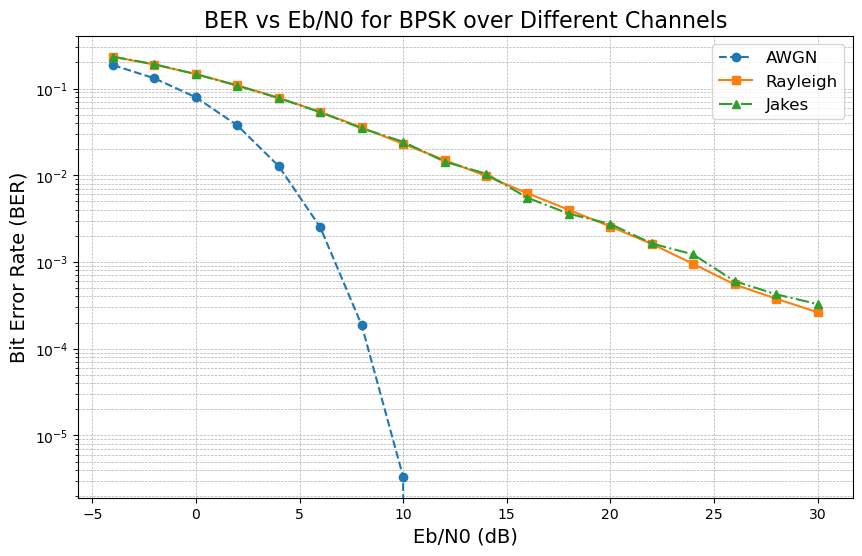

In [208]:
import matplotlib.pyplot as plt
import numpy as np
snr_values_np = np.array(snr_values)

#plt.semilogy(Eb_N0_dB, theoryBerAWGN, 'cd-', linewidth=2, label='AWGN Theory')
#plt.semilogy(Eb_N0_dB, theoryBerRayleigh, 'bp-', linewidth=2, label='Rayleigh Theory')

plt.figure(figsize=(10, 6))

# Plot the BER for the AWGN channel
plt.plot(snr_values_np, ber_awgn_list, marker='o', linestyle='--', label='AWGN')

# Plot the BER for the Rayleigh fading channel
plt.plot(snr_values_np, ber_ray_list, marker='s', linestyle='-', label='Rayleigh')

# Plot the BER for the Jakes fading channel
plt.plot(snr_values_np, ber_jakes_list, marker='^', linestyle='-.', label='Jakes')

# Plot the BER for the packet-based channel
#plt.plot(snr_values_np, ber_packet_list, marker='d', linestyle=':', label='Packet-Based')

# Set the y-axis to a logarithmic scale
plt.yscale('log')
plt.xlabel('Eb/N0 (dB)', fontsize=14)
plt.ylabel('Bit Error Rate (BER)', fontsize=14)
plt.title('BER vs Eb/N0 for BPSK over Different Channels', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()